In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

In [3]:
import torch
import random
import numpy as np
from src.models import CustomDeepLabV3 as CDL
from src.utils.config import load_config
from src.data.transforms import build_transforms_from_config
from src.data.dataset import PancreasDataset
from torch.utils.data import DataLoader
from scripts.eval import visualize_model_predictions
from src.metrics.segmentation import SegmentationMetrics as SM
from src.metrics.segmentation_bak import SegmentationMetrics as SMbak

# __Load model checkpoint and set eval__

In [4]:
MODEL_PATH = 'experiments/deep_aug_randcrop/deep_aug_randcrop_20250319_074330/checkpoints/best_model_epoch21.pth'
model = CDL(num_classes=5, dropout_rate=0.2, pretrained=False)
checkpoint = torch.load(MODEL_PATH, map_location='cpu')['model']
model.load_state_dict(
    {k: v for k, v in checkpoint.items() if "aux_classifier" not in k},
    strict=False
)
model.eval()

CustomDeepLabV3(
  (deeplab): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [5]:
config = load_config('configs/experiments/deep_aug_randcrop.yaml')
transform = build_transforms_from_config(config.get('transforms', None))
val_dataset = PancreasDataset(
    data_dir=config['data']['raw_dir'],
    split_file=config['data']['split_path'],
    split_type='val',
    transform=transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config['data']['num_workers'],
    pin_memory=True
)

📊 Loading dataset (val)... 12 patients found.
📊 Dataset loaded with 1305 slices.


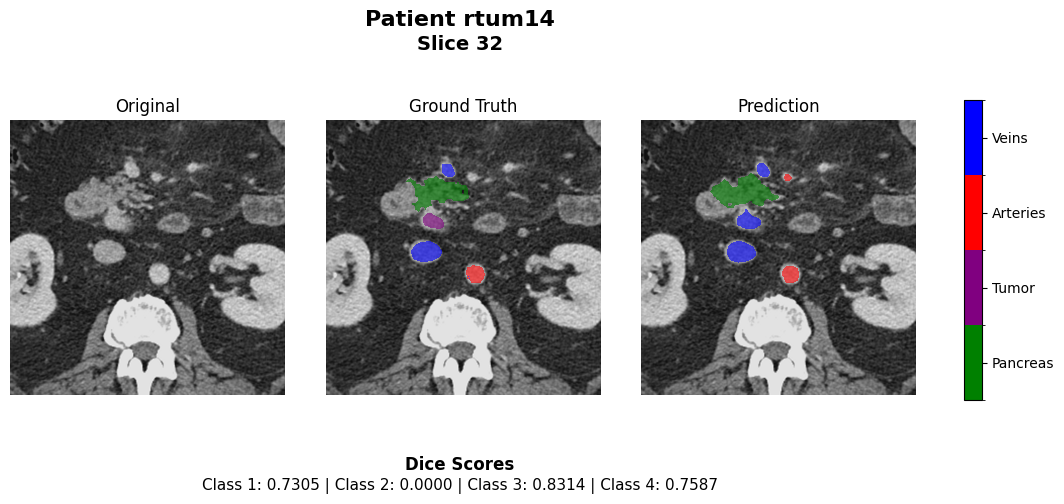

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_model_predictions(model, val_loader, device, 1)

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def test_prediction_scores(model, test_loader, device, num_images=1, alpha=0.5):
    cmap = mcolors.ListedColormap(['green', 'purple', 'red', 'blue'])
    boundaries = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    model.eval()
    indices = random.sample(range(len(test_loader.dataset)), num_images)

    for i, idx in enumerate(indices):
        image, mask, patient_id = test_loader.dataset[idx] 
        image, mask = image.to(device), mask.to(device)
        mask_un = mask.unsqueeze(0)

        with torch.no_grad():
            output = model(image.unsqueeze(0))["out"]
            print(output.shape)
            print(mask_un.shape)
            prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            ground_truth = mask.cpu().numpy()

        # Compute Dice Score for each class
        dice_scores = [
            2 * np.sum((prediction == class_idx) & (ground_truth == class_idx)) / 
            (np.sum(prediction == class_idx) + np.sum(ground_truth == class_idx) + 1e-6) 
            for class_idx in range(1, 5)
        ]

        _, dice_scores_actual = SM.dice_coefficient(output, mask_un)
        # print(dice_scores_actual)
        _, dice_scores_bak = SMbak.dice_coefficient(output, mask_un)
        # print(dice_scores_bak)

        print("DICE SCORES")
        class_names = {
            1: 'Pancreas',
            2: 'Tumor',
            3: 'Arteries',
            4: 'Veins'
        }
        print(f"{'Class':<10}{'Function':>15}{'Actual':>15}{'Previous':>15}")
        print("-" * 65)

        for idx in class_names:
            key = f'dice_class_{idx}'
            func = np.round(dice_scores[idx-1], 5)
            actual = np.round(dice_scores_actual[key], 5)
            previous = np.round(dice_scores_bak[key], 5)

            print(f"{class_names[idx]:<10}{func:>15,}{actual:>15,}{previous:>15,}")
        
        # Create overlays
        mask_overlay = np.where(ground_truth > 0, ground_truth, np.nan)
        prediction_overlay = np.where(prediction > 0, prediction, np.nan)

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        # Original image
        axes[0].imshow(image.squeeze().cpu(), cmap='gray')
        axes[0].set_title('Original', fontsize=12)
        axes[0].axis('off')

        # Ground Truth
        axes[1].imshow(image.squeeze().cpu(), cmap='gray')
        axes[1].imshow(mask_overlay, cmap=cmap, norm=norm, alpha=alpha)
        axes[1].set_title('Ground Truth', fontsize=12)
        axes[1].axis('off')

        # Model Prediction
        axes[2].imshow(image.squeeze().cpu(), cmap='gray')
        axes[2].imshow(prediction_overlay, cmap=cmap, norm=norm, alpha=alpha)
        axes[2].set_title('Prediction', fontsize=12)
        axes[2].axis('off')

        # Add Dice Scores in a single line below the images
        dice_text = " | ".join([f"Class {i+1}: {dice:.4f}" for i, dice in enumerate(dice_scores)])
        fig.text(0.5, 0.02, dice_text, ha='center', fontsize=11, color='black')
        fig.text(0.5, 0.06, "Dice Scores", ha='center', fontsize=12, fontweight='bold')

        # Set window title with patient ID and slice index
        slice_idx = idx - test_loader.dataset.get_initial_slice_idx(patient_id)
        fig.suptitle(f"Patient {patient_id}", fontsize=16, fontweight="bold")
        fig.text(0.5, 0.9, f"Slice {slice_idx}", ha='center', fontsize=14, fontweight="bold")

        # Colorbar (properly positioned)
        cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])  # Ajuste preciso
        colorbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
        colorbar.set_ticks([1, 2, 3, 4])
        colorbar.set_ticklabels(['Pancreas', 'Tumor', 'Arteries', 'Veins'])
        colorbar.ax.tick_params(labelsize=10)

        # Ajuste de espaciado
        plt.subplots_adjust(wspace=0.15, right=0.88, bottom=0.12, top=0.85)
        plt.show(block=(i == num_images - 1))

torch.Size([1, 5, 512, 512])
torch.Size([1, 512, 512])
else if
DICE SCORES
Class            Function         Actual       Previous
-----------------------------------------------------------------
Pancreas          0.44287        0.44287        0.43244
Tumor                 0.0            0.0            0.0
Arteries          0.92915        0.92915        0.92183
Veins             0.88681        0.88681        0.85926


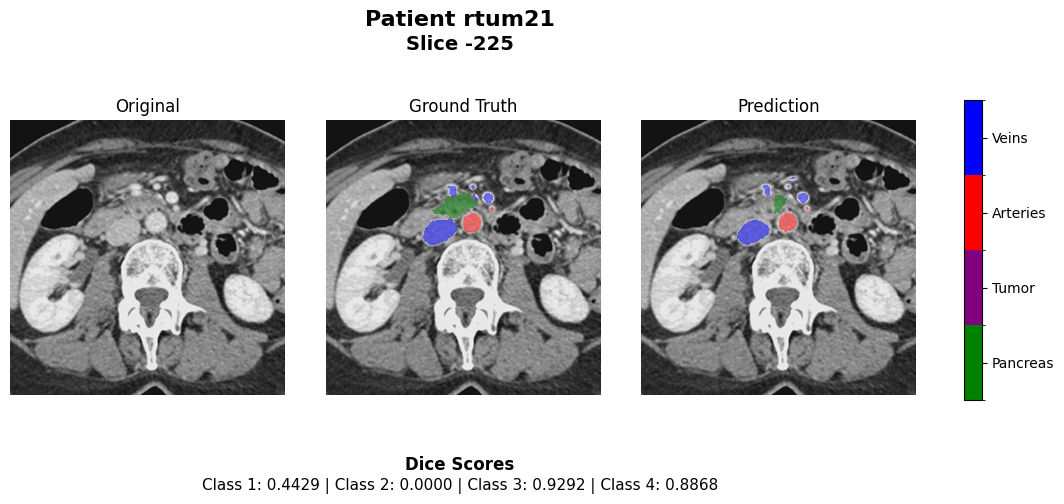

In [18]:
test_prediction_scores(model, val_loader, device, 1)

# __Testing results__

In [20]:
from src.metrics.segmentation_monai import SegmentationMonaiMetrics as SMM
from src.data.dataset2d import PancreasDataset2D

In [40]:
def test_full_dataset(model, ds):
    model.eval()
    
    for idx in range(len(ds)):
        image, mask, patient_id = ds[idx] 
        image, mask = image.to(device), mask.to(device)
        mask_un = mask.unsqueeze(0)

        with torch.no_grad():
            output = model(image.unsqueeze(0))["out"]
            prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            ground_truth = mask.cpu().numpy()

        # Compute Dice Score for each class
        dice_scores = [
            2 * np.sum((prediction == class_idx) & (ground_truth == class_idx)) / 
            (np.sum(prediction == class_idx) + np.sum(ground_truth == class_idx) + 1e-6) 
            for class_idx in range(1, 5)
        ]

        _, dice_scores_actual = SM.dice_coefficient(output, mask_un)
        _, dice_scores_bak = SMbak.dice_coefficient(output, mask_un)
        _, dice_scores_monai = SMM.compute_dice(output, mask_un)

        vol_slice = ds.get_volume_slice_idx(idx)

        print('='*100)
        print(f"DICE SCORES: {patient_id} - {vol_slice}")
        class_names = {
            1: 'Pancreas',
            2: 'Tumor',
            3: 'Arteries',
            4: 'Veins'
        }
        print(f"{'Class':<10}{'Function':>15}{'Actual':>15}{'Previous':>15}{'MONAI':>15}{'EQ func':>15}{'EQ new':>15}")
        print("-" * 100)

        for idx in class_names:
            key = f'dice_class_{idx}'
            func = np.round(dice_scores[idx-1], 6)
            actual = np.round(dice_scores_actual[key], 6)
            previous = np.round(dice_scores_bak[key], 6)
            monai = np.round(dice_scores_monai[key], 6)

            eq_func = func==monai
            eq = actual==monai

            print(f"{class_names[idx]:<10}{func:>15,}{actual:>15,}{previous:>15,}{monai:>15,}{eq_func:>15,}{eq:>15,}")

In [41]:
train_ds = PancreasDataset2D(
    data_dir='data/processed/2d/train',
    transform=transform,
    load_into_memory=False
)

📊 Loading dataset... 7004 slices found.


In [ ]:
test_full_dataset(model, train_ds)

# __Save metrics__

In [51]:
import csv
from tqdm import tqdm

In [57]:
NUM_CLASSES = 5
def save_comparison(model, ds, csv_file='dataset_eval.csv'):
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(['patient_id', 'slice', 'class', 'softmax', 'argmax'])

        model.eval()
    
        for idx in tqdm(range(len(ds))):
            image, mask, patient_id = ds[idx] 
            image, mask = image.to(device), mask.to(device)
            mask_un = mask.unsqueeze(0)
    
            with torch.no_grad():
                output = model(image.unsqueeze(0))["out"]
                prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
                ground_truth = mask.cpu().numpy()
    
            _, dice_scores_actual = SM.dice_coefficient(output, mask_un)
            _, dice_scores_bak = SMbak.dice_coefficient(output, mask_un)
    
            vol_slice = ds.get_volume_slice_idx(idx)

            for class_idx in range(NUM_CLASSES):
                key = f'dice_class_{class_idx}'
                actual = np.round(dice_scores_actual[key], 8)
                previous = np.round(dice_scores_bak[key], 8)

                writer.writerow([patient_id, vol_slice, class_idx, previous, actual])

    print(f"Finished. Saved: {csv_files}")

In [61]:
save_comparison(model, train_ds, 'train_eval.csv')

  1%|█▍                                                                                                                | 88/7004 [03:32<4:38:53,  2.42s/it]


KeyboardInterrupt: 